# Author: Himanshu Hemant Paithane

# Notebook 7: Logistic Regression for Smoking Prediction

In this notebook, we'll implement and evaluate Logistic Regression models for predicting smoking status based on health indicators. We'll use the cleaned datasets prepared in Notebook 1.

## Understanding Logistic Regression

Logistic Regression is a statistical model that uses a logistic function to model a binary dependent variable. Despite its name, logistic regression is a classification algorithm rather than a regression algorithm.

### How Logistic Regression Works:
1. It uses a linear combination of input features to predict the log-odds of the positive class
2. The log-odds are transformed using the sigmoid function to obtain probabilities between 0 and 1
3. If the probability is above a certain threshold (typically 0.5), the instance is classified as the positive class
4. The model is trained by finding the coefficients that maximize the likelihood of the observed data

### Advantages of Logistic Regression:
- Simple and interpretable (coefficients indicate feature importance and direction)
- Efficient to train, even on large datasets
- Provides well-calibrated probability estimates
- Less prone to overfitting than many complex models
- Works well for linearly separable data

### Limitations of Logistic Regression:
- Assumes a linear relationship between features and log-odds
- May underperform on complex, non-linear relationships
- Sensitive to feature scaling
- Can be affected by multicollinearity
- Struggles with imbalanced datasets unless properly adjusted

In this notebook, we'll implement logistic regression with some optimization of regularization strength and class weights to improve performance for our smoking prediction task.

## 1. Import Libraries and Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler  # Standard scaling is typically better for linear models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Set random seed for reproducibility
RANDOM_STATE = 42

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the full and reduced datasets
df_full = pd.read_csv('smoking_cleaned_full.csv')
df_reduced = pd.read_csv('smoking_cleaned_reduced.csv')

# Display basic information about the datasets
print(f"Full dataset shape: {df_full.shape}")
print(f"Reduced dataset shape: {df_reduced.shape}")

# Verify that both datasets have the target variable
print(f"\nTarget variable 'smoking' distribution in full dataset:\n{df_full['smoking'].value_counts()}")
print(f"\nTarget variable 'smoking' distribution in reduced dataset:\n{df_reduced['smoking'].value_counts()}")

Full dataset shape: (44084, 30)
Reduced dataset shape: (44084, 16)

Target variable 'smoking' distribution in full dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64

Target variable 'smoking' distribution in reduced dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64


## 2. Data Preparation for Logistic Regression

Logistic Regression is sensitive to feature scaling because it uses the magnitude of the feature values in its calculations. Features with larger scales can dominate those with smaller scales. Therefore, feature scaling is important for optimal performance and to ensure that regularization affects all features equally.

We'll use StandardScaler to standardize our features (mean=0, variance=1), which is generally preferred for linear models like Logistic Regression.

In [3]:
# Separate features and target for both datasets
X_full = df_full.drop('smoking', axis=1)
y_full = df_full['smoking']

X_reduced = df_reduced.drop('smoking', axis=1)
y_reduced = df_reduced['smoking']

# Split the data into training and testing sets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
)

X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_reduced
)

# Apply feature scaling (StandardScaler for linear models)
scaler_full = StandardScaler()
X_full_train_scaled = scaler_full.fit_transform(X_full_train)
X_full_test_scaled = scaler_full.transform(X_full_test)

scaler_reduced = StandardScaler()
X_reduced_train_scaled = scaler_reduced.fit_transform(X_reduced_train)
X_reduced_test_scaled = scaler_reduced.transform(X_reduced_test)

print("Data preparation for Logistic Regression completed successfully.")
print(f"Training set size: {X_full_train.shape[0]} samples")
print(f"Testing set size: {X_full_test.shape[0]} samples")
print(f"Full feature set: {X_full.shape[1]} features")
print(f"Reduced feature set: {X_reduced.shape[1]} features")

Data preparation for Logistic Regression completed successfully.
Training set size: 35267 samples
Testing set size: 8817 samples
Full feature set: 29 features
Reduced feature set: 15 features


## 3. Optimizing Logistic Regression Parameters

Unlike some other models, Logistic Regression is deterministic and not affected by the random_state parameter once the data splitting is fixed. However, other parameters can significantly affect its performance:

1. **C**: The inverse of regularization strength. Smaller values specify stronger regularization, which can help prevent overfitting. Default is C=1.0.

2. **class_weight**: Weights associated with classes. Can help with imbalanced datasets by adjusting the importance of classes during training. Options include None (all classes have weight one), 'balanced' (automatically adjust weights inversely proportional to class frequencies), or a dictionary of weights.

Let's optimize these parameters to improve our model's performance.

In [4]:
# Define a range of C values to test (regularization strength)
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Define class_weight options
class_weights = [None, 'balanced']

# Use cross-validation to find the best parameters
# We'll use the reduced feature set for faster computation
print("Optimizing Logistic Regression parameters...")
best_score = 0
best_params = {}

for C in C_values:
    for class_weight in class_weights:
        # Create and train the model
        lr = LogisticRegression(
            C=C,
            class_weight=class_weight,
            max_iter=500,  # Increase max_iter to ensure convergence
            random_state=RANDOM_STATE
        )
        
        # Use 5-fold cross-validation with F1 score
        scores = cross_val_score(lr, X_reduced_train_scaled, y_reduced_train, cv=5, scoring='f1')
        mean_score = scores.mean()
        
        print(f"C={C}, class_weight={class_weight}: Mean F1 Score = {mean_score:.4f}")
        
        # Update best parameters if we found a better score
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'C': C, 'class_weight': class_weight}

print(f"\nBest parameters: {best_params}")
print(f"Best F1 score: {best_score:.4f}")

Optimizing Logistic Regression parameters...
C=0.001, class_weight=None: Mean F1 Score = 0.6279
C=0.001, class_weight=balanced: Mean F1 Score = 0.7005
C=0.01, class_weight=None: Mean F1 Score = 0.6556
C=0.01, class_weight=balanced: Mean F1 Score = 0.7030
C=0.1, class_weight=None: Mean F1 Score = 0.6593
C=0.1, class_weight=balanced: Mean F1 Score = 0.7033
C=1.0, class_weight=None: Mean F1 Score = 0.6594
C=1.0, class_weight=balanced: Mean F1 Score = 0.7032
C=10.0, class_weight=None: Mean F1 Score = 0.6596
C=10.0, class_weight=balanced: Mean F1 Score = 0.7032
C=100.0, class_weight=None: Mean F1 Score = 0.6595
C=100.0, class_weight=balanced: Mean F1 Score = 0.7032

Best parameters: {'C': 0.1, 'class_weight': 'balanced'}
Best F1 score: 0.7033


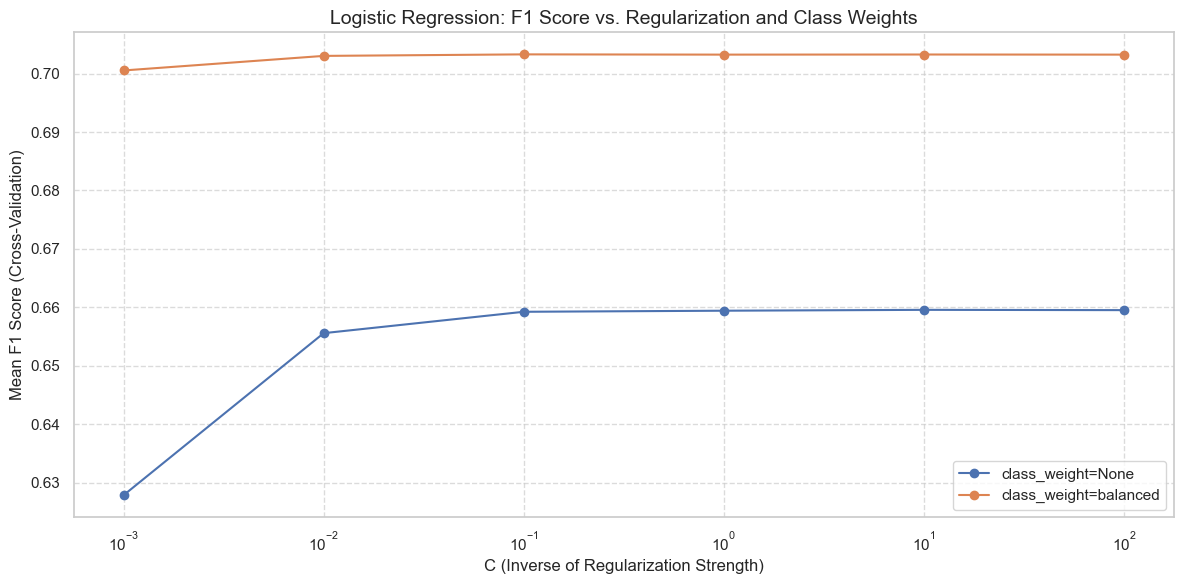

In [5]:
# Visualize the impact of C and class_weight on F1 score
# Create a dataframe to store results
results = []
for C in C_values:
    for class_weight in class_weights:
        lr = LogisticRegression(C=C, class_weight=class_weight, max_iter=500, random_state=RANDOM_STATE)
        scores = cross_val_score(lr, X_reduced_train_scaled, y_reduced_train, cv=5, scoring='f1')
        results.append({
            'C': C,
            'class_weight': str(class_weight),  # Convert to string for plotting
            'F1_Score': scores.mean()
        })

results_df = pd.DataFrame(results)

# Plot F1 score vs. C for different class_weights
plt.figure(figsize=(12, 6))
for class_weight in class_weights:
    subset = results_df[results_df['class_weight'] == str(class_weight)]
    plt.plot(subset['C'], subset['F1_Score'], marker='o', label=f'class_weight={class_weight}')

plt.xscale('log')  # Use log scale for C values
plt.xlabel('C (Inverse of Regularization Strength)', fontsize=12)
plt.ylabel('Mean F1 Score (Cross-Validation)', fontsize=12)
plt.title('Logistic Regression: F1 Score vs. Regularization and Class Weights', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Training Logistic Regression Models with Optimal Parameters

Now that we've identified the optimal parameters, let's train our final models for both the full and reduced feature sets:

In [6]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    """Calculate and return performance metrics for a classification model."""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC AUC (if probability predictions are available)
    roc_auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

# Train Logistic Regression with optimal parameters for full feature set
print("Training Logistic Regression model with full feature set...")
lr_full = LogisticRegression(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    max_iter=500,
    random_state=RANDOM_STATE
)
lr_full.fit(X_full_train_scaled, y_full_train)

# Train Logistic Regression with optimal parameters for reduced feature set
print("Training Logistic Regression model with reduced feature set...")
lr_reduced = LogisticRegression(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    max_iter=500,
    random_state=RANDOM_STATE
)
lr_reduced.fit(X_reduced_train_scaled, y_reduced_train)

# Make predictions
y_full_pred = lr_full.predict(X_full_test_scaled)
y_reduced_pred = lr_reduced.predict(X_reduced_test_scaled)

# Get probability predictions
y_full_prob = lr_full.predict_proba(X_full_test_scaled)[:, 1]
y_reduced_prob = lr_reduced.predict_proba(X_reduced_test_scaled)[:, 1]

# Evaluate performance
full_metrics = evaluate_model(y_full_test, y_full_pred, y_full_prob)
reduced_metrics = evaluate_model(y_reduced_test, y_reduced_pred, y_reduced_prob)

# Display results
print("\nLogistic Regression Model with Full Feature Set:")
print(f"Accuracy: {full_metrics['accuracy']:.4f}")
print(f"Precision: {full_metrics['precision']:.4f}")
print(f"Recall: {full_metrics['recall']:.4f}")
print(f"F1 Score: {full_metrics['f1_score']:.4f}")
print(f"ROC AUC: {full_metrics['roc_auc']:.4f}")

print("\nLogistic Regression Model with Reduced Feature Set:")
print(f"Accuracy: {reduced_metrics['accuracy']:.4f}")
print(f"Precision: {reduced_metrics['precision']:.4f}")
print(f"Recall: {reduced_metrics['recall']:.4f}")
print(f"F1 Score: {reduced_metrics['f1_score']:.4f}")
print(f"ROC AUC: {reduced_metrics['roc_auc']:.4f}")

Training Logistic Regression model with full feature set...
Training Logistic Regression model with reduced feature set...

Logistic Regression Model with Full Feature Set:
Accuracy: 0.7222
Precision: 0.5756
Recall: 0.9131
F1 Score: 0.7061
ROC AUC: 0.8302

Logistic Regression Model with Reduced Feature Set:
Accuracy: 0.7107
Precision: 0.5628
Recall: 0.9327
F1 Score: 0.7020
ROC AUC: 0.8244


## 5. Understanding the Evaluation Metrics

Let's understand what each metric means in the context of our smoking prediction problem:

1. **Accuracy**: The proportion of correct predictions (both smokers and non-smokers correctly identified) out of all predictions. While intuitive, accuracy can be misleading in imbalanced datasets like ours (63% non-smokers vs. 37% smokers).

2. **Precision**: The proportion of true positive predictions (correctly identified smokers) among all positive predictions. In our context: "When the Logistic Regression model predicts someone is a smoker, how often is it right?" High precision means fewer false positives (non-smokers incorrectly classified as smokers).

3. **Recall (Sensitivity)**: The proportion of true positive predictions (correctly identified smokers) among all actual smokers. In our context: "Of all actual smokers, how many did the Logistic Regression model correctly identify?" High recall means fewer false negatives (smokers incorrectly classified as non-smokers).

4. **F1 Score**: The harmonic mean of precision and recall, providing a single metric that balances both concerns. This is particularly useful in our case with moderate class imbalance, as it gives equal importance to both precision and recall.

5. **ROC AUC**: Area Under the Receiver Operating Characteristic curve, which measures the model's ability to distinguish between smokers and non-smokers across all possible classification thresholds. Values range from 0.5 (no discriminative power, equivalent to random guessing) to 1.0 (perfect discrimination).

The choice of which metric to prioritize depends on the specific application:
- For applications where false positives are costly (e.g., unnecessary medical interventions), precision should be prioritized.
- For public health screening where missing smokers is more concerning, recall would be more important.
- In balanced scenarios, F1 score and ROC AUC provide good overall assessments of model performance.

## 6. Examining Feature Coefficients

One of the key advantages of Logistic Regression is its interpretability. The model's coefficients directly indicate each feature's importance and direction of influence. Let's examine these coefficients to gain insights about which health indicators are most predictive of smoking status:

Logistic Regression Coefficients (Reduced Feature Set):
              Feature  Coefficient  Abs_Coefficient
0              gender     1.346411         1.346411
1       ldl_hdl_ratio     0.480586         0.480586
2                 gtp     0.404573         0.404573
3                 ldl    -0.366671         0.366671
4        triglyceride     0.353650         0.353650
5           height_cm     0.224575         0.224575
6          hemoglobin     0.195738         0.195738
7                 alt    -0.184224         0.184224
8   cholesterol_ratio    -0.181145         0.181145
9    serum_creatinine    -0.177572         0.177572
10          weight_kg    -0.173685         0.173685
11                hdl     0.129896         0.129896
12           bp_ratio    -0.081528         0.081528
13                age    -0.049883         0.049883
14           waist_cm     0.013204         0.013204


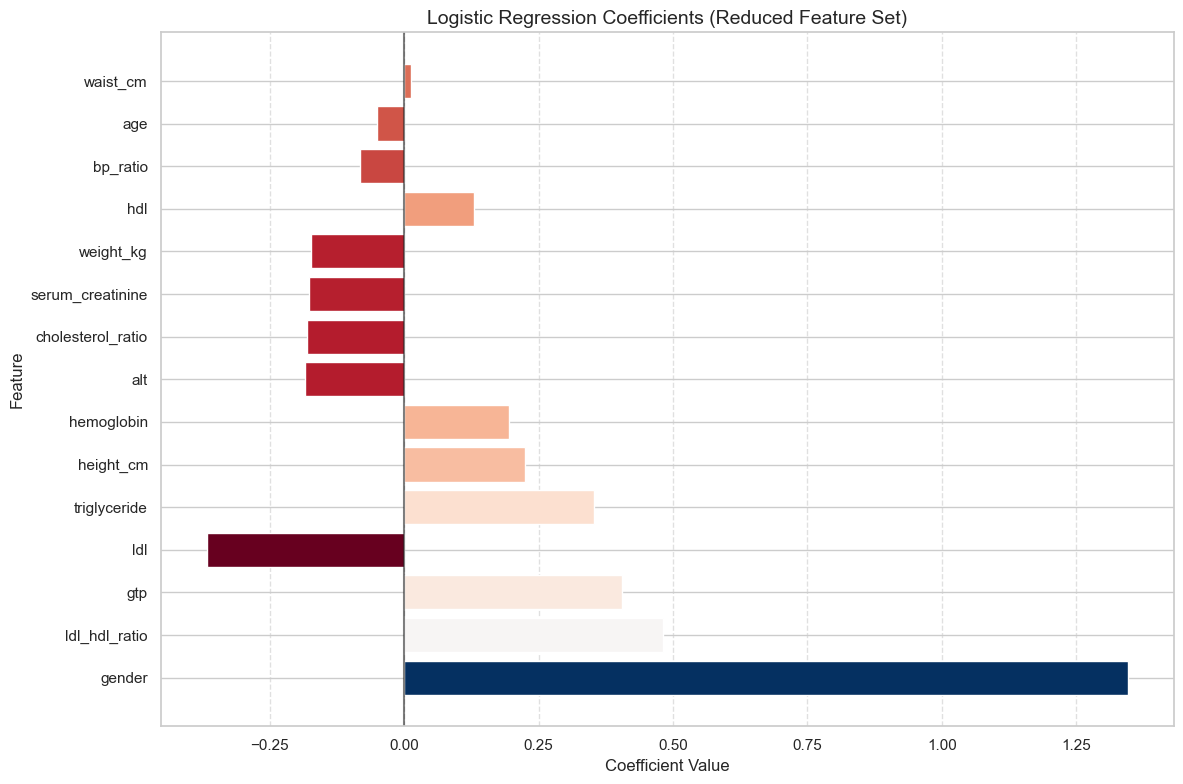

In [7]:
# Get feature coefficients from the reduced model (more interpretable with fewer features)
coefficients = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Coefficient': lr_reduced.coef_[0]
})

# Sort by absolute coefficient value to find most influential features
coefficients['Abs_Coefficient'] = abs(coefficients['Coefficient'])
coefficients_sorted = coefficients.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

# Display the coefficients
print("Logistic Regression Coefficients (Reduced Feature Set):")
print(coefficients_sorted)

# Plot coefficients
plt.figure(figsize=(12, 8))
plt.barh(y=coefficients_sorted['Feature'], width=coefficients_sorted['Coefficient'], 
         color=plt.cm.RdBu(np.interp(coefficients_sorted['Coefficient'], 
                                    [coefficients_sorted['Coefficient'].min(), 
                                     coefficients_sorted['Coefficient'].max()], 
                                    [0, 1])))
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)  # Add a vertical line at x=0
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression Coefficients (Reduced Feature Set)', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 7. Visualizing Model Performance

Confusion Matrix for Full Feature Set:


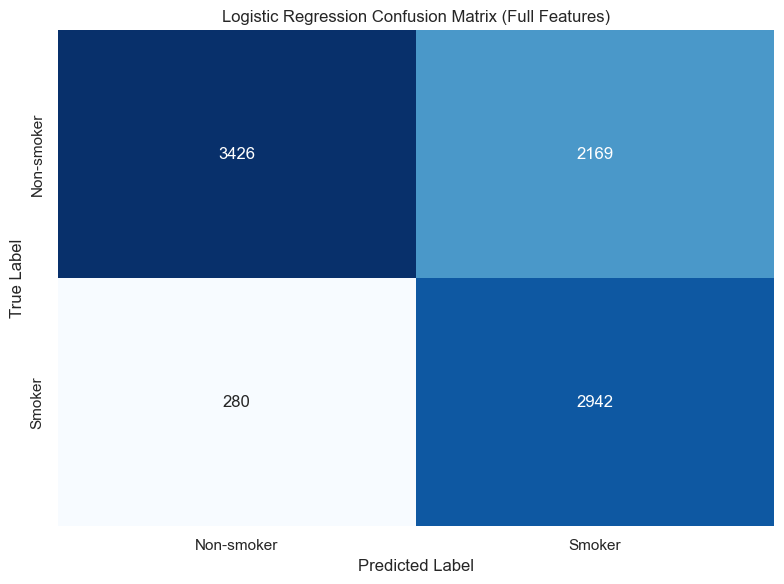

Specificity (True Negative Rate): 0.6123
Negative Predictive Value: 0.9244

Confusion Matrix for Reduced Feature Set:


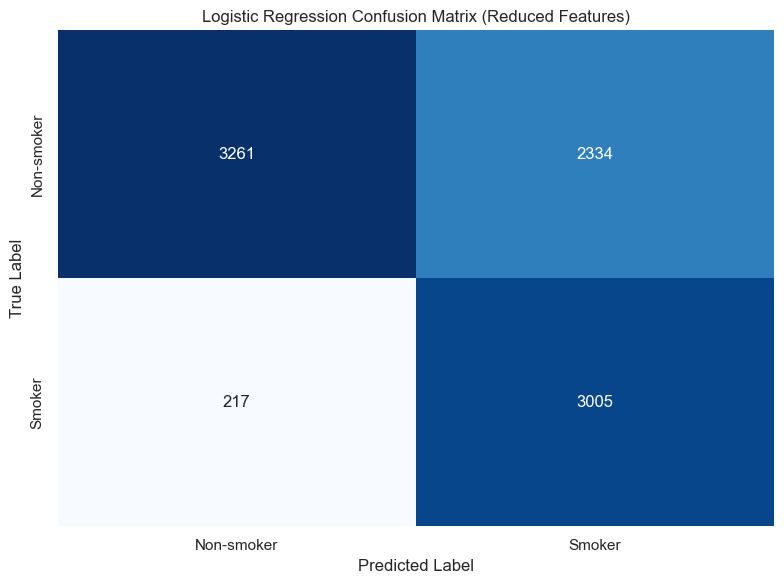

Specificity (True Negative Rate): 0.5828
Negative Predictive Value: 0.9376


In [8]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Non-smoker', 'Smoker'],
               yticklabels=['Non-smoker', 'Smoker'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display derived metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    npv = tn / (tn + fn)  # Negative predictive value
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")

# Function to plot ROC curves
def plot_roc_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Display confusion matrices
print("Confusion Matrix for Full Feature Set:")
plot_confusion_matrix(y_full_test, y_full_pred, 'Logistic Regression Confusion Matrix (Full Features)')

print("\nConfusion Matrix for Reduced Feature Set:")
plot_confusion_matrix(y_reduced_test, y_reduced_pred, 'Logistic Regression Confusion Matrix (Reduced Features)')

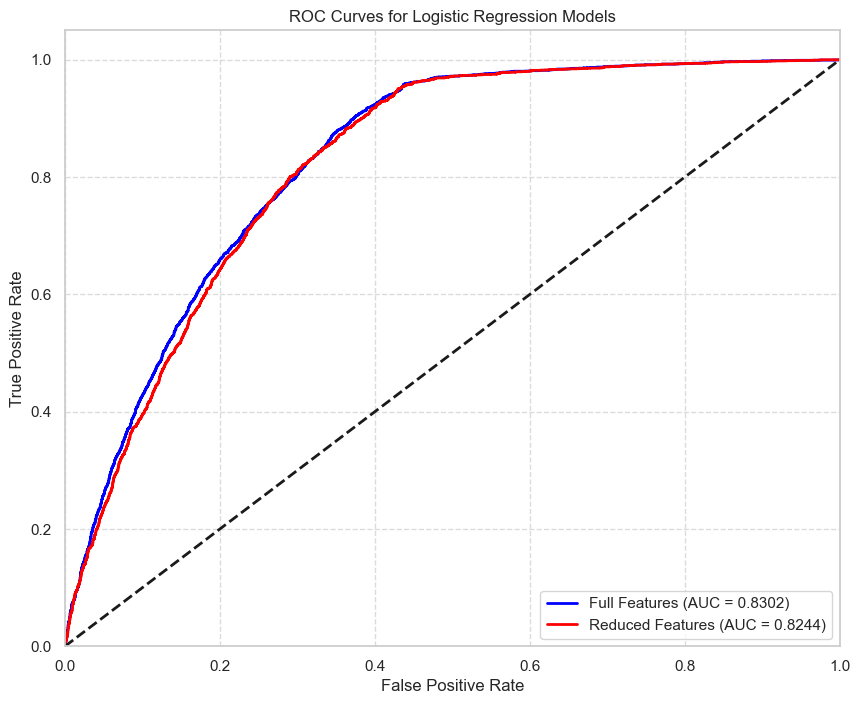

In [9]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for the full feature model
fpr_full, tpr_full, roc_auc_full = plot_roc_curve(y_full_test, y_full_prob, 'Full')
plt.plot(fpr_full, tpr_full, label=f'Full Features (AUC = {roc_auc_full:.4f})', lw=2, color='blue')

# Plot ROC curve for the reduced feature model
fpr_reduced, tpr_reduced, roc_auc_reduced = plot_roc_curve(y_reduced_test, y_reduced_prob, 'Reduced')
plt.plot(fpr_reduced, tpr_reduced, label=f'Reduced Features (AUC = {roc_auc_reduced:.4f})', lw=2, color='red')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 8. Comparison of Feature Sets

Let's directly compare the performance of our full and reduced feature sets to see how much predictive power we retain with fewer features:

In [10]:
# Create a comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Full Features': [
        full_metrics['accuracy'],
        full_metrics['precision'],
        full_metrics['recall'],
        full_metrics['f1_score'],
        full_metrics['roc_auc']
    ],
    'Reduced Features': [
        reduced_metrics['accuracy'],
        reduced_metrics['precision'],
        reduced_metrics['recall'],
        reduced_metrics['f1_score'],
        reduced_metrics['roc_auc']
    ]
})

# Calculate differences and percentage changes
metrics_comparison['Absolute Difference'] = metrics_comparison['Full Features'] - metrics_comparison['Reduced Features']
metrics_comparison['Percentage Change (%)'] = (metrics_comparison['Absolute Difference'] / metrics_comparison['Full Features']) * 100

# Display the comparison
print("Comparison of Logistic Regression Performance: Full vs. Reduced Feature Sets")
metrics_comparison.set_index('Metric')

Comparison of Logistic Regression Performance: Full vs. Reduced Feature Sets


,Full Features,Reduced Features,Absolute Difference,Percentage Change (%)
Metric,,,,
Accuracy,0.722241,0.710673,0.011569,1.601759
Precision,0.575621,0.562839,0.012782,2.220510
Recall,0.913097,0.932651,-0.019553,-2.141400
F1 Score,0.706108,0.702021,0.004087,0.578871
ROC AUC,0.830229,0.824445,0.005783,0.696584


<Figure size 1200x800 with 0 Axes>

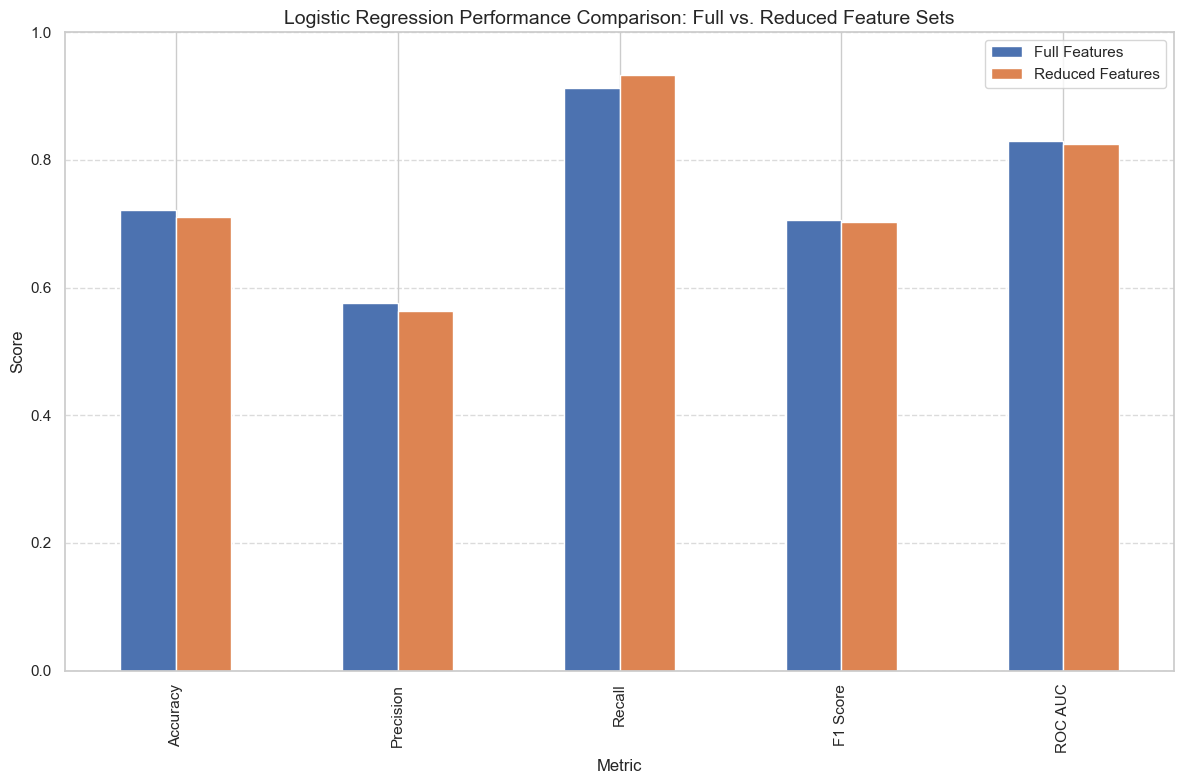

In [11]:
# Visualize the comparison
plt.figure(figsize=(12, 8))
metrics_comparison.set_index('Metric').loc[:, ['Full Features', 'Reduced Features']].plot(kind='bar')
plt.title('Logistic Regression Performance Comparison: Full vs. Reduced Feature Sets', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Save Results for Comparison with Other Models

Let's save our Logistic Regression model performance metrics to CSV files for later comparison with other models:

In [12]:
# Create DataFrames for saving results
lr_full_results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Feature_Set': ['Full'],
    'Accuracy': [full_metrics['accuracy']],
    'Precision': [full_metrics['precision']],
    'Recall': [full_metrics['recall']],
    'F1_Score': [full_metrics['f1_score']],
    'ROC_AUC': [full_metrics['roc_auc']]
})

lr_reduced_results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Feature_Set': ['Reduced'],
    'Accuracy': [reduced_metrics['accuracy']],
    'Precision': [reduced_metrics['precision']],
    'Recall': [reduced_metrics['recall']],
    'F1_Score': [reduced_metrics['f1_score']],
    'ROC_AUC': [reduced_metrics['roc_auc']]
})

# Combine results
lr_results = pd.concat([lr_full_results, lr_reduced_results], ignore_index=True)

# Add hyperparameter information
lr_results['Hyperparameters'] = [
    f"C={best_params['C']}, class_weight={best_params['class_weight']}",
    f"C={best_params['C']}, class_weight={best_params['class_weight']}"
]

# Save results to CSV
lr_results.to_csv('logistic_regression_model_results.csv', index=False)
print("Saved Logistic Regression model results to logistic_regression_model_results.csv")

# Display the final results table
lr_results

Saved Logistic Regression model results to logistic_regression_model_results.csv


,Model,Feature_Set,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Hyperparameters
0,Logistic Regression,Full,0.722241,0.575621,0.913097,0.706108,0.830229,"C=0.1, class_weight=balanced"
1,Logistic Regression,Reduced,0.710673,0.562839,0.932651,0.702021,0.824445,"C=0.1, class_weight=balanced"
